<a href="https://colab.research.google.com/github/michaeljf00/text_summarizer/blob/roham/BBCDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !unzip data.zip

In [18]:
pip -q install sumy numpy seaborn pandas nltk tensorflow-gpu torch matplotlib transformers Iprogress sentencepiece

     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 10.1 MB 61.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random

## BBC News Summary EDA
TODO: add general description here

### Data preperation
To get started please paste the BBC news dataset into a folder titled data in the local directory. Then delete 199.txt in the articles and summaries directory respectively due to corruption with these files.

In [5]:
def get_text_by_topic(directory_path):
    data = []
    count = 0
    for topic in os.listdir(directory_path):
        topic_path = os.path.join(directory_path, topic)
        if not os.path.isdir(topic_path):
          continue
        for file_path in os.listdir(topic_path):
            try:
                with open(f'{topic_path}/{file_path}', 'r', encoding="utf-8") as f:
                    data.append(( topic_path.split('/')[-1],f.read()))
                count+=1
            except UnicodeDecodeError:
                print(f'file {file_path} in {topic_path} is not readable')
                print(UnicodeDecodeError)
    df = pd.DataFrame(data, columns=['label','text'])
    print(f"Total Items loaded: {count}")
    return df
                      
articles_path = r"data/BBC News Summary/News Articles"
summaries_path = r"data/BBC News Summary/Summaries"

articles_df = get_text_by_topic(articles_path)
summaries_df = get_text_by_topic(summaries_path)
articles_df.head()

file .DS_Store in data/BBC News Summary/News Articles/sport is not readable
<class 'UnicodeDecodeError'>
Total Items loaded: 2224
file .DS_Store in data/BBC News Summary/Summaries/sport is not readable
<class 'UnicodeDecodeError'>
Total Items loaded: 2224


,label,text
0,business,Worldcom director ends evidence\n\nThe former ...
1,business,Asian banks halt dollar's slide\n\nThe dollar ...
2,business,Ryanair in $4bn Boeing plane deal\n\nBudget ai...
3,business,Giant waves damage S Asia economy\n\nGovernmen...
4,business,Mystery surrounds new Yukos owner\n\nThe fate ...


### Lets see an example from the dataset

In [6]:
print("Articles Shape: ",articles_df.shape)
print("Summaries Shape: ",summaries_df.shape)
# If this fails the wrong number of aricles or summaries was loaded
assert(articles_df.shape == summaries_df.shape)

ex_idx = int(random.random()*articles_df.shape[0])
ex_topic = articles_df["label"][ex_idx]
print(f"\nRandom Example Article in {ex_topic}:")
print(articles_df["text"][ex_idx])
print(f"Random Example Summary in {ex_topic}:")
print(summaries_df["text"][ex_idx])

Articles Shape:  (2224, 2)
Summaries Shape:  (2224, 2)

Random Example Article in entertainment:
De Niro film leads US box office

Film star Robert De Niro has returned to the top of the North American box office with his film Hide and Seek.

The thriller shot straight to the number one spot after taking $22m (£11.7m) at the box office. De Niro recently spent three weeks at the top with comedy Meet The Fockers, which was at number five this week. Oscar hopefuls The Aviator, Million Dollar Baby and Sideways all cashed in on their multiple nominations with stronger ticket sales.

In Hide and Seek, De Niro plays a widower whose daughter has a creepy imaginary friend. Despite lukewarm reviews from critics, the film took more than the expected $18m (£9.5m). "The element of a real actor in a psychological thriller certainly elevated it," said Bruce Snyder, president of domestic distribution at 20th Century Fox. Clint Eastwood's Million Dollar Baby led the Oscar hopefuls with $11.8m (£6.3m), 

From this example we can see the dataset consists of BBC articles and co-responding summaries that are constructed in an extractive manner, that is, each summary is constructed by selecting a subset of the sentances in the original article.

In [7]:
# Null Checks
articles_df.isna().sum()
summaries_df.isna().sum()

label    0
text     0
dtype: int64

Next looking into the balance of each topic in the dataset

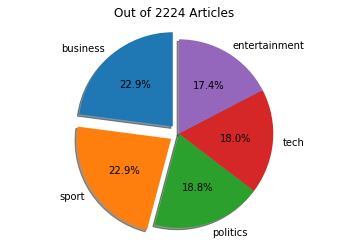

In [8]:
# Percent articles in each topic
label_vals = articles_df["label"].value_counts()

labels = list(label_vals.keys())
sizes = list(label_vals)
explode = [0]*len(sizes) 
explode[0] =0.1
explode[1] =0.1
fig1, ax1 = plt.subplots()
ax1.pie(label_vals, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"Out of {articles_df.shape[0]} Articles")
plt.show()


The classes appear to be well balance so model performance should be equivelent across topics

99th percentile in sentance count:  63.0


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


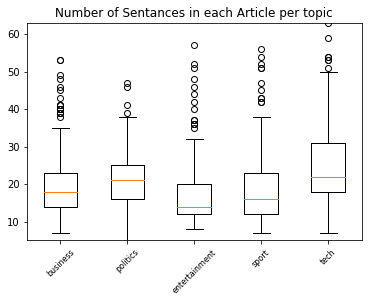

,business,politics,entertainment,sport,tech
count,510.000000,417.000000,386.000000,510.000000,401.000000
mean,19.680392,22.227818,17.945596,18.280392,25.842893
std,7.409560,15.467658,14.270836,9.876736,12.904370
min,7.000000,5.000000,8.000000,7.000000,7.000000
25%,14.000000,16.000000,12.000000,12.000000,18.000000
50%,18.000000,21.000000,14.000000,16.000000,22.000000
75%,23.000000,25.000000,20.000000,23.000000,31.000000
max,53.000000,246.000000,205.000000,82.000000,161.000000


In [9]:
# Number of Sentances in articles per topic
def get_text_length(daf, split):
    text_lens = [[len(t.split(split)) for t in daf["text"][daf['label'] == label]] for label in daf['label'].unique()]
    return text_lens

# Splitting on . for each sentance
text_lens = get_text_length(articles_df, ".")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in sentance count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Sentances in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

It appears that tech articles have the longest articles in terms of sentances however the categories seem to be balanced here aswell. Noteably there are some drastic outliars for article length with 200+ sentances that may have to be removed.

99th percentile in Word count:  475.0


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


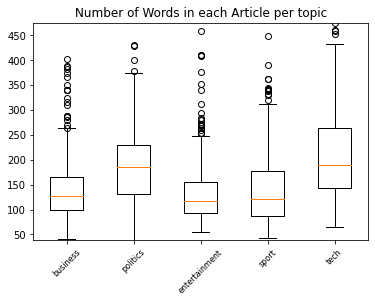

,business,politics,entertainment,sport,tech
count,510.00000,417.000000,386.00000,510.000000,401.000000
mean,139.94902,195.738609,144.07772,143.194118,213.880299
std,59.48480,139.855957,124.31821,80.966871,111.675336
min,40.00000,38.000000,54.00000,42.000000,65.000000
25%,99.00000,132.000000,93.25000,87.000000,144.000000
50%,127.00000,186.000000,117.00000,122.000000,189.000000
75%,164.75000,230.000000,154.75000,178.500000,264.000000
max,403.00000,2074.000000,1708.00000,659.000000,1433.000000


In [10]:
# Number of Words in articles per topic (splitting on " ")
text_lens = get_text_length(summaries_df, " ")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in Word count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Words in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

Comparing the word counts to the sentance counts we can see the same outliar issue exists as well as sports having less words despite having more sentances implying that sentance length will vary based on the topic.

### Next looking at the ground truth reduction in word count

In [11]:
# Summary length reduction per topic by word count
articles_len = get_text_length(articles_df, " ")
summaries_len = get_text_length(summaries_df, " ")


# For each Topic
print("Average percent reduction in words for ...")
for i,topic in enumerate(articles_df['label'].unique()):
    # 1  - ratio of summary to article length
    avg_percent_reduction = np.mean(1-np.asarray(summaries_len[i])/np.asarray(articles_len[i]))
    print(f"{topic} summaries: {100*avg_percent_reduction:0.4f}%")

Average percent reduction in words for ...
business summaries: 56.8027%
politics summaries: 56.5632%
entertainment summaries: 56.0781%
sport summaries: 55.5133%
tech summaries: 57.2868%


From this we see across the board roughly half of the words are dropped in the ground truth summaries implying our model should have a similar dropout rate. This also may indicate classification may be a valid approach to determining whether a sentance should remain in the summary. Running this code over with sentance count reveals a similar trend implying no relationship between sentance length and likelyhood to be in the summmary.

### EDA with common heuristics in NLP

In extractive text summarization a common baseline model is to simply take the first few sentances (typically 3) of a peice of text as the summary as writers often introduce their main points in the beggining of articles. We will analyze the effectiveness of this heuristic for the BBC model for possible consideration for a baseline model

In [12]:
# For regular expression
import re
# for sentance parsing
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# turn each article into a list of sentances
def get_sentances(texts_list):
    documents = []
    for text in texts_list:
        documents.append(sent_tokenize(text.replace("\n\n",". ").replace(".. ",". ").replace(".",". ").replace(".  ",". ")))
    return documents
    #return [[a.strip() for a in t.replace("\n\n",".").split(".") if a!=''] for t in texts_list]

# First sentance inclusion in summary
article_sentances = get_sentances(articles_df["text"])
summary_sentances = get_sentances(summaries_df["text"])

# Check how many sentances (up to the fourth) of the article are in the summary
counts = [0]*4
for a,s in zip(article_sentances,summary_sentances):
    for i in range(len(counts)):
        if a[i+1] in s:
            counts[i]+=1
        else:
            break
print(f"{100*counts[0]/len(article_sentances):0.2f}% Article summaries include the first sentance of the article")
print(f"{100*counts[1]/len(article_sentances):0.2f}% Article summaries include the first and second")
print(f"{100*counts[2]/len(article_sentances):0.2f}% Article summaries include the first, second, and third")
print(f"{100*counts[3]/len(article_sentances):0.2f}% Article summaries include the first, second, third and fourth")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


69.83% Article summaries include the first sentance of the article
36.29% Article summaries include the first and second
17.81% Article summaries include the first, second, and third
7.33% Article summaries include the first, second, third and fourth


From this a good baseline model to compare text summarization would simply be to use the first few sentances of each article as the summary. The performance of this method is best with including one to two sentances

In [13]:
# Rarity of words used

In [14]:
# Overall use of stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Most common words after stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Additional NLP statistics

## Metrics


In [25]:
#ROUGE METRICS
import numpy as np
import os
from textblob import TextBlob
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.models.dom import Sentence
from sumy.evaluation.rouge import rouge_1,rouge_2

# #iterating over different number of sentence counts
# article_path = r"data/BBC News Summary/News Articles"
# summary_path = r"data/BBC News Summary/Summaries"

# for sc in [10,15,20,25]:
#     r1=[]
#     r2=[]
#     for i in os.listdir(article_path):
#         #getting the file path
#         file = article_path+i 
#         #parsing the artile file
#         parser = PlaintextParser.from_file(file, Tokenizer("english"))
#         #initialising the summarizer
#         summarizer = TextRankSummarizer()
#         #summarizing the article
#         summary = summarizer(parser.document, sc) 
        
#         #acquiring the actual summary
#         f=open(summary_path+i,'r')
#         act=f.read()
#         act_sum=act.split('.')
#         final=[]
#         #typecasting into sentences using Sentence model
#         for i in act_sum:
#             final.append(Sentence(i,Tokenizer('english')))
        
#         #calculating the rouge scores for the summary obtained
#         r1.append(rouge_1(summary,final))
#         r2.append(rouge_2(summary,final))
        
#     #averaging the rouge scores for a sentence count
#     print('For sentence count:',sc)
#     print('Average Rouge 1 score:',sum(r1)/len(r1))
#     print('Average Rouge 2 score:',sum(r2)/len(r2),'\n\n')

# #source: https://github.com/R11Raj/Text-summarization-of-BBC-Business-Articles/blob/master/Text%20summarization.ipynb

In [26]:
#BLEU METRICS EXAMPLE
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


## Base Line Model
From the EDA we found that an effective baseline model would be taking the first two sentances of the article as the predicted summary

In [27]:
# Each base line prediction is the first two sentaces of the article
def base_line_predict(articles_df):
    predictions = []
    article_sentances = get_sentances(articles_df["text"])
    for a in article_sentances:
        predictions.append(a[1:3])
    return predictions

pred = base_line_predict(articles_df)
print(f"Example baseline: {pred[0]}\n")
print(f"Example summary: {summary_sentances[0]}")

Example baseline: ['The former chief financial officer at US telecoms firm WorldCom has finished giving evidence at the trial of his ex-boss Bernie Ebbers.', 'Scott Sullivan admitted to jurors he was willing to commit fraud to meet Wall Street earnings projections.']

Example summary: ["Mr Sullivan, 42, has already pleaded guilty to fraud and will be sentenced following Mr Ebbers' trial, where he is appearing as a prosecution witness.", 'Mr Sullivan has spent two days being cross-examined by lawyers for former Worldcom chief executive Mr Ebbers.', "Mr Ebbers is on trial for fraud and conspiracy in relation to WorldCom's collapse in 2002.", "Mr Ebbers, 63, has always insisted that he was unaware of any hidden shortfalls in WorldCom's finances.", "Attorney Reid Weingarten has attempted to portray Mr Sullivan as a liar and on Thursday quizzed him about his decision to commit fraud to meet analysts' profit estimates.", 'The former finance officer said Mr Ebbers knew about the improper acco

## Preprocessing For Extractive Text Summarization

In [ ]:
from nltk.tokenize import word_tokenize
def compare_sentances(sentance_a, sentance_b):
    tok_a = word_tokenize(sentance_a)
    tok_b = word_tokenize(sentance_b)
    matches = 0
    for tok in tok_a:
        if tok in tok_b:
            matches+=1
    return float(matches)/len(tok_a)
    
# Generate Label
def generate_labels(articles_df, summaries_df):
    article_sentances = get_sentances(articles_df["text"])
    summary_sentances = get_sentances(summaries_df["text"])
    labels = []
    count=0
    total_sentances = 0
    same = 0
    for article,summary in zip(article_sentances,summary_sentances):
        sentance_inclusion = []
        for sentance_a in article:
            if len(sentance_a)<3:
                continue
            in_summary = False
            for sentance_b in summary:
                if len(sentance_b)<3:
                    continue
                percent_match = compare_sentances(sentance_a, sentance_b)
                if percent_match > 0.95:
                    in_summary=True
                    break
            total_sentances+=1
            if in_summary:
                sentance_inclusion.append(1)
            else:
                sentance_inclusion.append(0)
        #print(np.sum(sentance_inclusion), len(summary))
        same+=np.sum(sentance_inclusion) == len(summary)
        count+=1
        print(f"Percent Complete: {100*count/len(article_sentances):0.2f}%",end="\r")
        #assert(np.sum(sentance_inclusion) == len(summary))
        #print(sentance_inclusion)
        labels.append(sentance_inclusion)
        #print(article)
        #print(summary)
        #assert(np.sum(sentance_inclusion) == len(summary))
        
    #print(total_sentances)
    print()
    print("Matching  labels ",same)
    print("Total ",len(article_sentances))
    print(f"Total Sentances processed {total_sentances}")
    return labels

#print(articles_df["text"][1])
y_labels = generate_labels(articles_df, summaries_df) 
print(np.sum(np.sum(y_labels)))

# Expand contractions
# lowercase
# Remove digits and words containing digits
# Remove punctuations
# Remove stop words

# Remove Contractions and other anomolies

# Vectorize sentance

## Preprocessing For Abstractive Text Summarization

In [ ]:
# Import tokenizer from pretrained model
from transformers import AutoTokenizer, TFAutoModelWithLMHead, AutoModelForSeq2SeqLM

model_name = "t5-small"

model = TFAutoModelWithLMHead.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# MAX_INPUT_LENGTH = 512
# MAX_TARGET_LENGTH = 30

# def preprocess_function(article, summary):
#     model_inputs = tokenizer(
#         article,
#         max_length=MAX_INPUT_LENGTH,
#         truncation=True
#     )
#     labels = tokenizer(
#         summary,
#         max_length=MAX_TARGET_LENGTH,
#         truncation=True
#     )
#     #model_inputs["labels"] = articles["labels"]
#     return model_inputs

# for i in range(articles_df.shape[0]):
#     result = preprocess_function(articles_df["text"][0], summaries_df["text"][0])

In [ ]:
def abstract_tokenize(tokenizer, input_data):
  inputs = []

  for i in range(input_data.shape[0]):
    inputs.append(tokenizer.encode("summarize: " + input_data["text"][i], # required prefix
                              return_tensors = "tf",
                              max_length = 512, # required max_length
                              truncation = True))

  # readout
  print("Tokenized", len(inputs), "entries")
  print()
  print("Sample tokenized input:")
  print(inputs[0])

  return inputs

In [ ]:
tokenized_array = abstract_tokenize(tokenizer, articles_df)

## Abstractive Text Summarization (with T5-Small)

In [ ]:
def abstract_summarize(model, tokenized_input):
  outputs = []

  for i in range(len(tokenized_input)):
    outputs.append(model.generate(tokenized_input[i],
                            max_length=200,
                            min_length=30,
                            length_penalty=2.0,
                            num_beams=2,
                            early_stopping=True,
                            no_repeat_ngram_size=3))

  # readout
  print("Summarized", len(outputs), "entries")

  return outputs

In [ ]:
def abstract_prediction(tokenizer, summarized_input):
  prediction = []

  for i in range(len(summarized_input)):
    prediction.append([tokenizer.decode(token,
                                  skip_special_tokens=True,
                                  clean_up_tokenization_spaces=True)
                                  for token in summarized_input[i]])

  # readout
  print("Decoded", len(prediction), "predicted summaries")

  print()
  print("Sample article:")
  print(summaries_df["text"][0])

  print()
  print("Sample prediction:")
  print(prediction[0][0])

  return prediction

In [ ]:
summarized_array = abstract_summarize(model, tokenized_array[:5])

In [ ]:
prediction_array = abstract_prediction(tokenizer, summarized_array)